1. Create a neural network that performs dimensionality reduction using PCA and then reconstructs the input data, considering that

$X\in \mathbb{R}^{N\times P}$ and the network $\hat{X}=(f_1 \circ f_0)(X)$ must satisfy that it has weights $W_0$ and $W_1$ in the first and second layers respectively, and it must satisfy that $W_0=W_1^T$.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, losses, Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input

2024-02-27 14:35:08.236855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 14:35:08.236991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 14:35:08.412199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


For this exercise, I am going to use the MNIST dataset.

In [2]:
# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
scale = 0.4
x_train = x_train.astype('float32') / 255. + np.random.normal(scale=scale,size=x_train.shape)
x_test = x_test.astype('float32') / 255. + np.random.normal(scale=scale,size=x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train = x_train.reshape((x_train.shape[0], 28*28))
x_test = x_test.reshape((x_test.shape[0], 28*28))

x_val = x_train[50000:]
y_val = y_train[50000:]
x_train = x_train[:50000]
y_train = y_train[:50000]

To impose the restriction that $W_1 = W_0^T$, I propose creating a new class to customize the second layer of my neural network.

In [4]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)

    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z)

In [5]:
input_dim = 784  # MNIST
encoding_dim = 46  # dimensionality reduction

# Input layer
input_layer = Input(shape=(input_dim,))
f0 = Dense(encoding_dim, activation='linear')
f0_tensor  = f0(input_layer)

# Output layer
f1 = DenseTranspose(f0, activation='linear')
f1_tensor = f1(f0_tensor)

# Model
model = Model(inputs=input_layer, outputs=f1_tensor)

In [6]:
model.compile(optimizer='adam', loss='mean_squared_error')

# datos_x serían tus datos de entrenamiento
model.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_val, x_val))

Epoch 1/20
196/196 [==============================] - 2s 7ms/step - loss: 0.1911 - val_loss: 0.1732
Epoch 2/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1698 - val_loss: 0.1675
Epoch 3/20
196/196 [==============================] - 1s 6ms/step - loss: 0.1663 - val_loss: 0.1654
Epoch 4/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1649 - val_loss: 0.1647
Epoch 5/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1644 - val_loss: 0.1644
Epoch 6/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1642 - val_loss: 0.1642
Epoch 7/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1641 - val_loss: 0.1641
Epoch 8/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1641 - val_loss: 0.1641
Epoch 9/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1641 - val_loss: 0.1641
Epoch 10/20
196/196 [==============================] - 1s 5ms/step - loss: 0.1640 - val_loss: 0.1641

Now, I am interested in knowing how similar my input is to the newly reconstructed dataset.

In [7]:
x_pca = model.predict(x_train)
mse = mean_squared_error(x_train, x_pca)
print(r"The mean square error between $X$ and $\hat{X}$ is: %s" % mse)

1563/1563 [==============================] - 3s 2ms/step
The mean square error between $X$ and $\hat{X}$ is: 0.16366213471179453


On the other hand, let's take a look at some elements of our input and their reconstructed form.

In [8]:
def plot_mnist_autoencoder(x, xpred, cmap='gray', vmin=0, vmax=1):
  fig,ax = plt.subplots(2, x.shape[0], figsize=(8,1))
  for i,class_ in enumerate(range(x.shape[0])):
        ax[0,i].imshow(x[i].reshape(28, 28), cmap=cmap,vmin=vmin,vmax=vmax)
        ax[0,i].set_xticks([])

        ax[0,i].set_yticks([])

        ax[1,i].imshow(xpred[i].reshape(28, 28),cmap=cmap,vmin=vmin,vmax=vmax)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
  plt.show()
  return

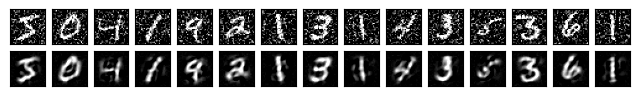

In [9]:
plot_mnist_autoencoder(x_train[0:15],x_pca[0:15])